# COMP2200/COMP6200 Prac - Week 4

_Author: Benjamin Pope (benjamin.pope@mq.edu.au)_

---

In lectures this week we learned about fitting models to data - linear and logistic regression. In this practical we will use `scikit-learn` to model higher-dimensional data, including polynomial regression for the fish market dataset, with ridge and lasso regression. We will also look at logistic regression for the Titanic dataset.

**Please submit the completed notebook for this workshop to your GitHub Classroom for marking!**

Remember that to use a notebook, you need to run each cell. If left side of a cell says `[ ]`, it hasn't been run. If the left side
says something like `[25]` then it has been. Shift-Enter runs a cell;  if you look around the user interface, various other menu items can run several cells in sequence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets, linear_model, preprocessing, metrics, model_selection
from glob import glob

---

There is a great dataset on Kaggle, which we looked at in part on Monday's lecture: the 'fish market dataset' containing dimensions and weight of fish. This is a good opportunity to [set up a Kaggle API key](https://www.kaggle.com/docs/api) if you haven't already, so that you can automatically download the dataset. 

In [3]:
# Load the Fish Market dataset from Kaggle

import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipullrathod/fish-market")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 2.38k/2.38k [00:00<00:00, 1.44MB/s]

Extracting model files...
Path to dataset files: /Users/sooresgoorong/.cache/kagglehub/datasets/vipullrathod/fish-market/versions/1


Always make a quick visualization of your data! In the code below, we are restricting ourselves to just a single species; modify this code to include all species.

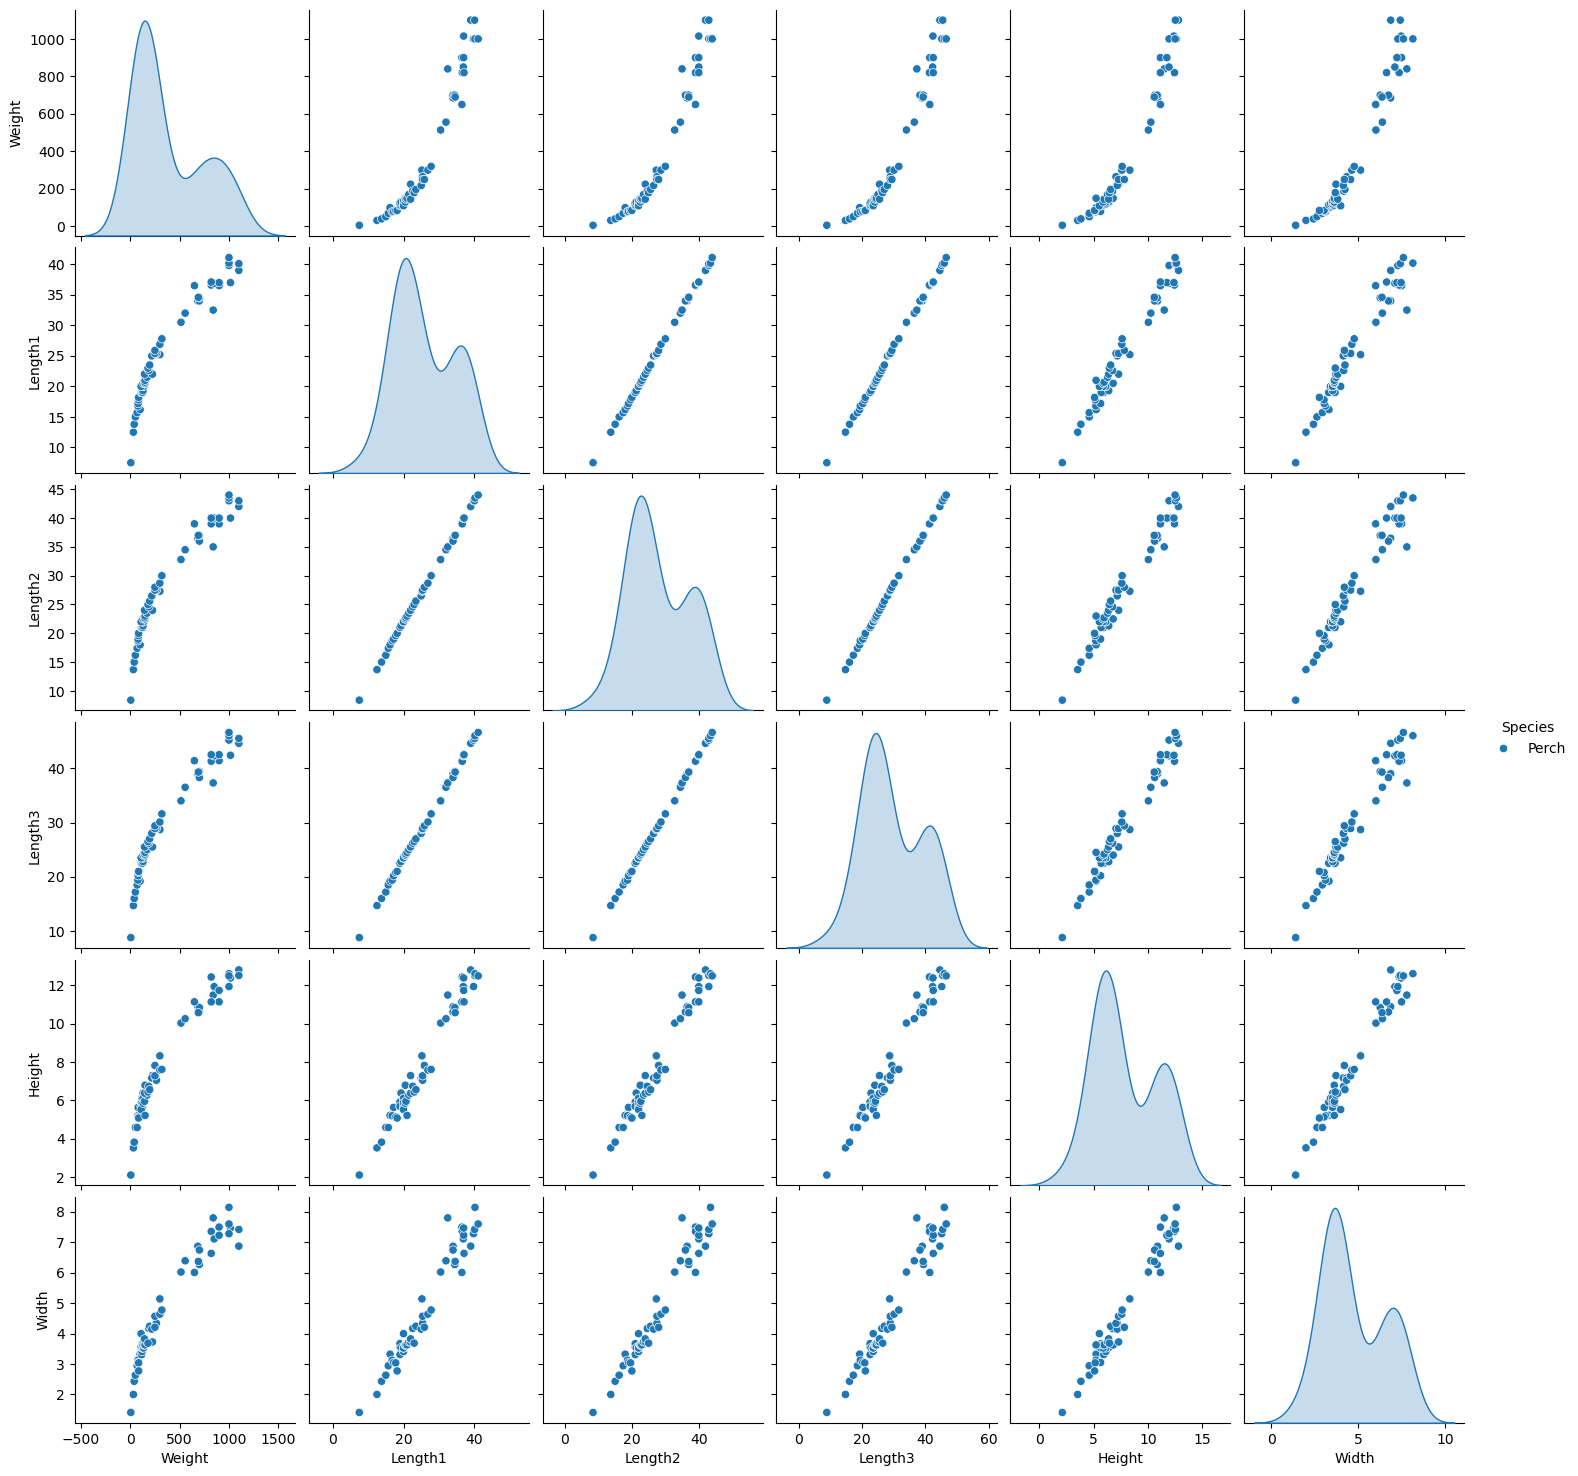

In [4]:
# Plot this
fname = glob(path + "/*.csv")[0]
df = pd.read_csv(fname)
pair = sns.pairplot(df[df.Species=='Perch'],hue="Species",kind='scatter')

First you want to preprocess the data to be normalized. 

(Advanced: skip this step and see what happens to the results of the regression models! We expect polynomial models to become unstable.)

In [5]:
scaler = preprocessing.MinMaxScaler()
params = ['Weight','Length1','Length2','Length3','Height','Width']

scaler.fit(df[params])
df[params] = scaler.transform(df[params])

First, in the cell below, create test and training sets, using `sklearn.model_selection.train_test_split`. A good split is 80% training and 20% testing.

In [6]:
train, test = model_selection.train_test_split(df[df.Species=='Perch'], test_size=0.2)

Let us begin by doing some linear regression between the linear dimensions of the fish, just to play around with some things that really are pretty linear. 

In the cell below, use `sklearn.linear_model.LinearRegression` to fit a linear model to the fish market data, showing examples for:
- Width vs. Length1, Length2, Length3
- Height vs. Length1, Length2, Length3
- Width vs. Height
- Width vs both Length1 *and* Height - doing multilinear regression

For each of these, print the coefficients and the

- R-squared, 
- RMSE, and 
- MAE  

values for the training and testing data. Which performed the best on training? Which performed the best on test?

*Always* overplot the predictions on the data, and make sure to label the axes and the plot.


In [10]:
model = linear_model.LinearRegression()
Y = train['Width']
X = np.array(train[['Length1', 'Length2', 'Length3']])
model.fit(X, Y)
print("Model coefficients:", model.coef_)

Model coefficients: [ 0.09232012 -0.85991693  2.30138144]


Advanced: use the design matrix from above to calculate the uncertainty in the coefficients, models from a multivariate normal distribution, and illustrate the uncertainty in the model.

In [12]:
residuals = model.predict(X) - Y
uncertainty = np.std(residuals)

In [13]:
uncertainty

0.05275319812132612

Now we want to do something more advanced: as we know, the weight of something scales with the volume, which is not linear at all! We should do a *polynomial* regression.

In [15]:
poly = preprocessing.PolynomialFeatures(degree=3)

poly_features = poly.fit_transform(X)
model.fit(poly_features, Y);
print("Model coefficients:", model.coef_)


Model coefficients: [ 0.00000000e+00  5.35725143e+00  9.14214799e-01 -6.40981661e+00
  2.32693338e+03 -7.88984836e+03  3.30662754e+03  5.04036846e+03
 -2.35048684e+03 -4.26158759e+02 -7.44724359e+05  2.28010602e+06
 -4.57527307e+04 -1.55930719e+06 -1.45226942e+06  7.76976756e+05
 -9.90514305e+04  1.87132957e+06 -1.15452067e+06  1.27204918e+05]


Text(0, 0.5, 'Frequency')

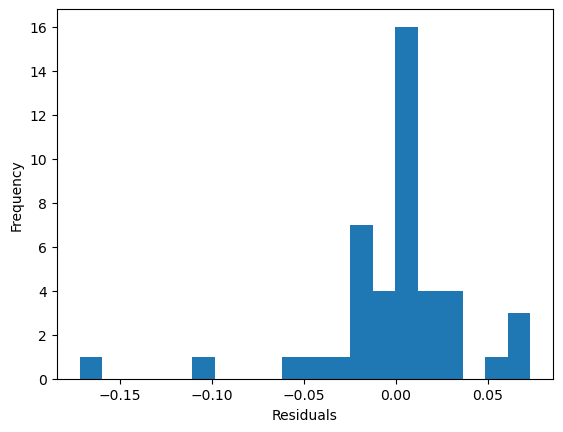

In [16]:
residuals = model.predict(poly_features) - Y
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")

There is an efficient way to automate taking multiple steps: `sklearn.pipeline.Pipeline`. 

We use it like this:

In [21]:
from sklearn.pipeline import Pipeline

r2s = []
maes = []
rmses = []

# max_order = 10

r2s_train = []
maes_train = []
rmses_train = []

max_order = 10

X = np.array(train[['Length1', 'Length2', 'Length3']])
Y = np.array(train['Width'])
X_test = np.array(test[['Length1', 'Length2', 'Length3']])
Y_test = np.array(test['Width'])

for polyfeatures in range(1, max_order):
    
    steps = [
        ("scalar", preprocessing.StandardScaler()), # scaling is especially important when using polynomial features
        ("poly", preprocessing.PolynomialFeatures(degree = polyfeatures)),
        ("model", linear_model.LinearRegression())
    ]

    pipe = Pipeline(steps)

    pipe.fit(X, train['Weight'])

    r2 = metrics.r2_score(test['Weight'], pipe.predict(X_test))
    mae = metrics.median_absolute_error(test['Weight'], pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(test['Weight'], pipe.predict(X_test)))
    r2s.append(r2) # r2
    maes.append(mae) # median absolute error
    rmses.append(rmse) # root mean squared error
    print(f"Order : {polyfeatures},Train R2: {r2s_train},mae_train :{maes_train}")

Order : 1,Train R2: [],mae_train :[]
Order : 2,Train R2: [],mae_train :[]
Order : 3,Train R2: [],mae_train :[]
Order : 4,Train R2: [],mae_train :[]
Order : 5,Train R2: [],mae_train :[]
Order : 6,Train R2: [],mae_train :[]
Order : 7,Train R2: [],mae_train :[]
Order : 8,Train R2: [],mae_train :[]
Order : 9,Train R2: [],mae_train :[]


Using this framework, explore what polynomial order fits the data best, and generate the summary statistics for the training *and* testing data.

Which polynomial order fits the data best? Do you notice any overfitting - where the training data fits very well, but the testing data does not?

## Regularization

We have a lot of features in the design matrix as we go to high polynomial order - too many relative to the amount of data. This can lead to overfitting - but fortunately [we can deal with that using regularization](https://arxiv.org/abs/2101.07256).

Let's start with Ridge regression. Mathematically, this puts an L2 penalty on the size of the coefficients: where L2 means the sum of the squares of the coefficients. The Lasso model, on the other hand, puts an L1 penalty on the coefficients: where L1 means the sum of the *absolute values* of the coefficients. In this case your likelihood is

$$
\mathcal{L_\text{ridge}} = \underbrace{\sum_i \left( y_i - \sum_j X_{ij} \beta_j \right)^2}_{\text{log-likelihood}} + \underbrace{\alpha \sum_j \beta_j^2}_{\text{penalty}}
$$

where $\alpha$ is an arbitrary hyperparameter that controls the strength of the penalty.

In [22]:
# Use it like this
ridge = linear_model.Ridge(alpha = 0.1) # play with alpha
ridge.fit(X, train['Weight']);

lasso = linear_model.Lasso(alpha = 0.1) # play with alpha
lasso.fit(X, train['Weight']);

In the cell below, use a pipeline and a for loop, like above, to fit Ridge and Lasso models to the fish market data with a range of regularizations: which set of coefficients give you the best performance on the test data?

What do you think of the final results? What are the main coefficients?

Advanced: apply these methods to the entire fish market dataset. Do you get consistent results for the polynomial order for each species?

---

## Logistic Regression

We learned about logistic regression in lectures; now let's apply it to a real dataset. The fish market is too small for interesting logistic regression; and furthermore the fish species separate out very well in the feature space, so there is no challenge.

Let us now look at a dataset from the University of California, Irvine (UCI) Machine Learning Repository, about wine quality. This lists a number of wines - red and white - and continuous-valued chemical properties. One goal is to predict the quality of the wine based on these properties; but this is also a good opportunity to use a large dataset for logistic regression, to simply predict whether the wine is red or white.

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=186) 
wine_df = pd.DataFrame(wine.data.original)

In [ ]:
# normalize the data
scaler = preprocessing.MinMaxScaler()
print(list(wine_df.keys().copy())) # there are a lot of features - if you use all of these, it's too easy!

In [ ]:
params = ... # pick some features - try starting with 2 and going from there

small_wine = wine_df[[*params,'color']]

scaler.fit(small_wine[params])
small_wine[params] = scaler.transform(small_wine[params])
small_wine.head()

train, test = model_selection.train_test_split(small_wine, test_size=0.2)

Always visualize your data:

In [ ]:
sns.pairplot(train, hue='color', kind='kde');

Initialize a logistic regression model:

In [ ]:
logistic = linear_model.LogisticRegression()
logistic.C = 1e5 # play with C - this may need to vary - to do this systematically, use a loop and test
X = np.array(train[params])
logistic.fit(X, train.color=='red');

There is a great way to visualize the decision boundaries of a logistic regression model; let's import some things to do that:

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay # this is for rendering decision boundaries for 2d classifiers
# there are some nice blue and red colourmaps
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

In [ ]:
ax = plt.gca() # be able to access the axis so you can plot multiple things overlaid

DecisionBoundaryDisplay.from_estimator(
    logistic, X, cmap=cm, alpha=0.8, eps=0.1, fill_contours=True, ax=ax
)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=train.color=='red', cmap=cm_bright, edgecolors="k")

# Plot the testing points
X_test = np.array(test[params])
ax.scatter(X_test[:, 0], X_test[:, 1], c=test.color=='red', cmap=cm_bright, alpha=0.6, edgecolors="k")

ax.set_xlim(0,1)
ax.set_ylim(0,1)

Now we want to quantify the performance of the model. We can use the confusion matrix, which is a 2x2 matrix where the rows are the true classes and the columns are the predicted classes. The diagonal elements are the number of correct predictions, and the off-diagonal elements are the number of incorrect predictions.

In [ ]:
# confusion matrix
confusion = metrics.confusion_matrix(test.color=='red', logistic.predict(X_test))
sns.heatmap(confusion, annot=True)

How well do they separate? Do some sets of parameters overlap more or less? Try out the above calculation for different features. You may like to use for loops or other scripting to do this automatically. Store the results of the confusion matrix each time, and what percentage of data are on the diagonal vs off.

One way to quantify the performance of a classifier is to use the ROC curve. This is a plot of the true positive rate (TPR) against the false positive rate (FPR) as you vary the threshold for the classifier. Ideally, the true positive rate should be very high while keeping the false positive rate very low! The area under the curve (AUC) is a measure of the performance of the classifier: 1 is perfect (ie all true positives are found, no false positives are found), 0.5 is random (ie true positive rate = false positive rate = random).

In [ ]:
y = test.color=='red'
pred = logistic.predict_log_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

Set up a loop to optimize the AUC for the logistic regression, picking different features in pairs or triplets. Which features give the best AUC? What is the best AUC you can achieve?

## Advanced

In the cells below, use a pipeline to fit linear or logistic regression models to predict 

- (linear) wine quality, or 
- (logistic) where wine is top-quality (quality >5) or not, 

varying other parameter sets and regularization. Use the `quality` column to create a binary label, and use the other columns as features. You will need to consider all features, polynomials of those features, and regularization.